#### 大致流程
* 数据处理
* 模型及训练
* 预测

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_dir = 'data/train.csv'
test_dir = 'data/test.csv'

### 数据处理
* 读取数据
* 对训练集数据进行划分，将原始(240\*18)\*24的数据转化为若干18\*9的数据作为输入，第10个小时的pm2.5值作为输出,前9个小时必须是连续的，
    由于给出的数据是每个月前20天的，所以按月来分割数据,将(18\*20)\*24 转化为 (18\*480) 使得连续天数首尾相连,以步长为1连续取值

In [3]:
def read_data(file_name):
    data = pd.read_csv(file_name, encoding='big5') # 繁体字使用big5编码
    data = data.iloc[:, 3:] # 去掉前三列，因为前三列数据没用
    data = data.replace('NR', 0) # NR 表示不下雨，改为0
    data = np.array(data) # 转化为nunpy格式
    return data

In [4]:
train_data = read_data(train_dir)
train_data.shape

(4320, 24)

In [5]:
# 将每月的数据(18*20)*24 转化为 (18*480) 使得连续天数首尾相连
months_data = train_data.reshape(12, -1, 24) # 按月分割后的数据 (12*360*24)
print(months_data[1])

month_data_res = {}
month = 0
for month_data in months_data:
    sample = np.zeros([18, 480])
    for day in range(20):
        sample[:, day * 24:(day + 1) * 24] = month_data[18 * day:18 * (day + 1), :]  # 一天的开始取到一天的结尾
    month_data_res[month] = sample
    month += 1

[['15' '14' '14' ... '18' '17' '19']
 ['1.8' '1.8' '1.7' ... '1.8' '1.8' '1.7']
 ['0.27' '0.26' '0.25' ... '0.51' '0.37' '0.33']
 ...
 ['309' '82' '63' ... '72' '65' '69']
 ['2.2' '2.4' '2.5' ... '1.9' '2.9' '1.5']
 ['1.4' '1.3' '1.4' ... '0.9' '1.6' '1.1']]


In [6]:
# 以步长为1取值,每月20天一共480h，一共有471组数据
train_x = np.zeros([12 * 471, 18 * 9])
train_y = np.zeros([12 * 471, 1])
for month in range(12):
    for index in range(471):
        train_x[index + 471 * month, :] = month_data_res[month][:, index:index + 9].reshape(1, -1)
        train_y[index + 471 * month, :] = month_data_res[month][9, index + 9]
print(train_x[2])
print(train_y[2])
train_x.shape, train_y.shape

[1.40e+01 1.30e+01 1.20e+01 1.20e+01 1.20e+01 1.20e+01 1.50e+01 1.70e+01
 2.00e+01 1.80e+00 1.80e+00 1.80e+00 1.80e+00 1.80e+00 1.80e+00 1.80e+00
 1.80e+00 1.80e+00 3.90e-01 3.70e-01 3.50e-01 3.00e-01 3.70e-01 4.70e-01
 7.80e-01 7.40e-01 5.90e-01 1.30e-01 1.20e-01 1.10e-01 6.00e-02 1.00e-01
 1.30e-01 2.60e-01 2.30e-01 2.00e-01 5.00e-01 1.70e+00 1.80e+00 1.50e+00
 1.90e+00 2.20e+00 6.60e+00 7.90e+00 4.20e+00 8.20e+00 6.90e+00 6.80e+00
 3.80e+00 6.90e+00 7.80e+00 1.50e+01 2.10e+01 1.40e+01 8.70e+00 8.60e+00
 8.50e+00 5.30e+00 8.80e+00 9.90e+00 2.20e+01 2.90e+01 1.80e+01 2.70e+01
 2.30e+01 2.40e+01 2.80e+01 2.40e+01 2.20e+01 2.10e+01 2.90e+01 4.40e+01
 4.80e+01 3.50e+01 2.50e+01 1.20e+01 4.00e+00 2.00e+00 1.10e+01 3.80e+01
 5.60e+01 3.60e+01 3.50e+01 3.10e+01 2.80e+01 2.50e+01 2.00e+01 1.90e+01
 3.00e+01 4.10e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 6.70e+01 7.40e+01 7.20e+01 7.30e+01 7.40e+01
 7.30e+01 6.60e+01 5.60e+01 4.50e+01 1.70e+00 1.60e

((5652, 162), (5652, 1))

In [7]:
# 标准化 
mean_x = np.mean(train_x, axis = 0) # 取列均值
std_x = np.std(train_x, axis = 0)
print(mean_x.shape, std_x.shape)
for i in range(len(train_x)):
    for j in range(len(std_x)):
        if std_x[j] != 0:
            train_x[i][j] = (train_x[i][j] - mean_x[j]) / std_x[j]
        else:
            train_x[i][j] = (train_x[i][j] - mean_x[j])
print(train_x)

(162,) (162,)
[[-1.35825331 -1.35883937 -1.359222   ...  0.26650729  0.2656797
  -1.14082131]
 [-1.35825331 -1.35883937 -1.51819928 ...  0.26650729 -1.13963133
  -1.32832904]
 [-1.35825331 -1.51789368 -1.67717656 ... -1.13923451 -1.32700613
  -0.85955971]
 ...
 [-0.88092053 -0.72262212 -0.56433559 ... -0.57693779 -0.29644471
  -0.39079039]
 [-0.7218096  -0.56356781 -0.72331287 ... -0.29578943 -0.39013211
  -0.1095288 ]
 [-0.56269867 -0.72262212 -0.88229015 ... -0.38950555 -0.10906991
   0.07797893]]


In [8]:
train_x.shape

(5652, 162)

In [9]:
# 转化为tensor
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

# 数据集拆分
split_index = int(train_x.shape[0] * 0.8)
val_x = train_x[split_index:, :]
val_y = train_y[split_index:, :]

train_x = train_x[:split_index, :]
train_y = train_y[:split_index, :]

val_x.shape, train_x.shape, train_y.shape

(torch.Size([1131, 162]), torch.Size([4521, 162]), torch.Size([4521, 1]))

### 2.模型及训练

In [10]:
# 添加一个维度，就是bias
train_x = torch.cat([train_x, torch.ones([train_x.shape[0], 1]).double()], dim = 1).float()
val_x = torch.cat([val_x, torch.ones(val_x.shape[0], 1).double()], dim = 1).float()
train_x.shape, val_x.shape

(torch.Size([4521, 163]), torch.Size([1131, 163]))

In [71]:
w = torch.zeros(train_x.shape[1], 1)
lr = 0.00001
iter_time = 1000
num_train = train_x.shape[0]
num_val = val_x.shape[0]
adagrad = torch.zeros([train_x.shape[1], 1])
eps = 0.000001 # 防止为0

train_loss = torch.zeros(iter_time, 1)
val_loss = torch.empty(int(iter_time/100), 1)
for i in range(iter_time):
    pred = torch.mm(train_x, w)
    loss = torch.sum(torch.pow(pred - train_y, 2)) / num_train # 记得加根号，否则会导致loss太大
    train_loss[i] = loss
    if i % 100 == 0 and i != 0:
        val_pred = torch.mm(val_x, w)
        val_loss[int(i/100)] = torch.sum(torch.pow(val_pred - val_y, 2))/num_val
        
    gradient = torch.mm(train_x.t(), (pred - train_y).float())
    adagrad += gradient ** 2
#     w = w - lr * gradient / torch.sqrt(adagrad + eps)
    w = w - lr * gradient
 
    
train_loss.shape, val_loss.shape, w.shape

(torch.Size([1000, 1]), torch.Size([10, 1]), torch.Size([163, 1]))

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]


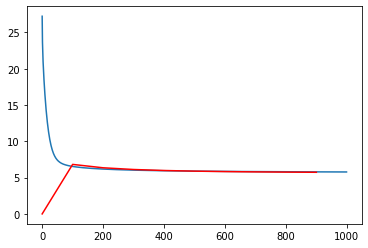

In [72]:
val_j = list(range(0, iter_time, 100))
train_j = list(range(0, iter_time, 1))
print(val_j)
plt.figure()
plt.plot(train_j, torch.sqrt(train_loss).data.numpy())
plt.plot(val_j, torch.sqrt(val_loss).data.numpy(), 'r-')
plt.show()

### 预测

In [77]:
test_data = pd.read_csv(test_dir, header=None)
test_data = test_data.iloc[:,2:] # 去除前两行数据
test_data = test_data.replace('NR', 0)
test_data = np.array(test_data)
test_data.shape

(4320, 9)

In [88]:
# 拼接数据 
assert test_data.shape[0] % 18 == 0
l = int(test_data.shape[0]/18)
print(l)
test_x = np.zeros((l, 18 * 9))
for i in range(l): # test_x的索引
    for j in range(18): # test_data的索引
        test_x[i, 9*j: 9*j +9] = test_data[i*18 + j]
test_x[1]

240


array([1.40e+01, 1.30e+01, 1.30e+01, 1.30e+01, 1.30e+01, 1.30e+01,
       1.30e+01, 1.20e+01, 1.30e+01, 1.80e+00, 1.80e+00, 1.80e+00,
       1.80e+00, 1.80e+00, 1.80e+00, 1.70e+00, 1.70e+00, 1.80e+00,
       3.30e-01, 3.30e-01, 3.30e-01, 3.50e-01, 3.40e-01, 3.30e-01,
       3.20e-01, 3.40e-01, 6.10e-01, 1.40e-01, 1.40e-01, 1.40e-01,
       1.50e-01, 1.50e-01, 1.20e-01, 1.00e-01, 9.00e-02, 1.90e-01,
       7.00e-01, 8.00e-01, 3.00e-01, 5.00e-01, 4.00e-01, 5.00e-01,
       4.00e-01, 3.00e-01, 2.00e+00, 1.00e+01, 8.70e+00, 7.80e+00,
       8.30e+00, 7.70e+00, 6.80e+00, 5.70e+00, 6.70e+00, 1.30e+01,
       1.10e+01, 9.40e+00, 8.10e+00, 8.70e+00, 8.10e+00, 7.30e+00,
       6.00e+00, 7.00e+00, 1.50e+01, 2.40e+01, 2.80e+01, 2.70e+01,
       2.30e+01, 2.20e+01, 2.80e+01, 3.00e+01, 3.10e+01, 2.40e+01,
       3.60e+01, 4.20e+01, 4.30e+01, 5.50e+01, 5.00e+01, 4.70e+01,
       4.50e+01, 4.00e+01, 3.30e+01, 1.70e+01, 2.20e+01, 1.70e+01,
       9.00e+00, 1.70e+01, 2.30e+01, 2.90e+01, 1.70e+01, 1.80e

In [ ]:
# 正则化
mean_x = np.mean(test_x, axis=0)
std_x = np.std(test_x, axis=0)

for i in range(len(test_x)):
    for j in range(len(std_x)):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
        else:
            test_x[i][j] = (test_x[i][j] - mean_x[j])

In [89]:
test_x = torch.from_numpy(test_x)
test_X = torch.cat([test_x, torch.ones([test_x.shape[0], 1]).double()], dim = 1)
test_X[1]

tensor([1.4000e+01, 1.3000e+01, 1.3000e+01, 1.3000e+01, 1.3000e+01, 1.3000e+01,
        1.3000e+01, 1.2000e+01, 1.3000e+01, 1.8000e+00, 1.8000e+00, 1.8000e+00,
        1.8000e+00, 1.8000e+00, 1.8000e+00, 1.7000e+00, 1.7000e+00, 1.8000e+00,
        3.3000e-01, 3.3000e-01, 3.3000e-01, 3.5000e-01, 3.4000e-01, 3.3000e-01,
        3.2000e-01, 3.4000e-01, 6.1000e-01, 1.4000e-01, 1.4000e-01, 1.4000e-01,
        1.5000e-01, 1.5000e-01, 1.2000e-01, 1.0000e-01, 9.0000e-02, 1.9000e-01,
        7.0000e-01, 8.0000e-01, 3.0000e-01, 5.0000e-01, 4.0000e-01, 5.0000e-01,
        4.0000e-01, 3.0000e-01, 2.0000e+00, 1.0000e+01, 8.7000e+00, 7.8000e+00,
        8.3000e+00, 7.7000e+00, 6.8000e+00, 5.7000e+00, 6.7000e+00, 1.3000e+01,
        1.1000e+01, 9.4000e+00, 8.1000e+00, 8.7000e+00, 8.1000e+00, 7.3000e+00,
        6.0000e+00, 7.0000e+00, 1.5000e+01, 2.4000e+01, 2.8000e+01, 2.7000e+01,
        2.3000e+01, 2.2000e+01, 2.8000e+01, 3.0000e+01, 3.1000e+01, 2.4000e+01,
        3.6000e+01, 4.2000e+01, 4.3000e+

In [92]:
pred_test = torch.mm(test_X, w.double())
pred_test

tensor([[  79.5168],
        [ 242.0930],
        [ 351.7156],
        [ 102.0415],
        [ 403.4229],
        [ 353.3746],
        [ 348.7181],
        [ 561.1282],
        [ 223.9062],
        [ 952.4991],
        [ 163.4331],
        [ 143.4245],
        [ 983.2729],
        [ 871.2963],
        [ 369.2992],
        [ 203.4178],
        [ 473.5663],
        [1079.1083],
        [ -27.4625],
        [ 255.3909],
        [ 670.1242],
        [1233.9780],
        [  77.7518],
        [ 230.6886],
        [ 236.8534],
        [ 665.0930],
        [ 223.5937],
        [1268.2135],
        [  39.3805],
        [ 890.7361],
        [ 319.6344],
        [ 110.9705],
        [ -26.6700],
        [ 339.0140],
        [ 547.7172],
        [ 547.1750],
        [ 712.9377],
        [ 521.0206],
        [ 681.4449],
        [ 615.8573],
        [  86.8952],
        [ 711.4779],
        [ 434.1626],
        [ 780.3232],
        [ 289.5823],
        [ 534.1913],
        [ 375.6277],
        [ 150

In [97]:
round(pred_test[0].item())

80